In [1]:
import os
opj = os.path.join

#os.environ["OMP_NUM_THREADS"] = "6"  # export OMP_NUM_THREADS=4
#os.environ["OPENBLAS_NUM_THREADS"] = "6"  # export OPENBLAS_NUM_THREADS=4
#os.environ["MKL_NUM_THREADS"] = "6"  # export MKL_NUM_THREADS=6
#os.environ["VECLIB_MAXIMUM_THREADS"] = "6"  # export VECLIB_MAXIMUM_THREADS=4
#os.environ["NUMEXPR_NUM_THREADS"] = "6"  # export NUMEXPR_NUM_THREADS=6
import mkl
mkl.set_num_threads(10)

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as pl
%matplotlib notebook
pl.ion()

import numpy as np
import yaml
import sys

sys.path.append("..")

from utils.utils import create_dm_from_screenshots, prepare_surface_data, prepare_volume_data
from prfpy.stimulus import PRFStimulus2D
from prfpy.grid import Iso2DGaussianGridder, Norm_Iso2DGaussianGridder, DoG_Iso2DGaussianGridder
from prfpy.fit import Iso2DGaussianFitter, Norm_Iso2DGaussianFitter, DoG_Iso2DGaussianFitter

Using TensorFlow backend.


In [2]:
subj = 'sub-001'
analysis_settings = '/Users/marcoaqil/prfpy_norm/analysis_settings.yml'

with open(analysis_settings) as f:
    analysis_info = yaml.safe_load(f)

# note that screenshot paths and task names should be in the same order
n_pix = analysis_info["n_pix"]
discard_volumes = analysis_info["discard_volumes"]
screenshot_paths = analysis_info["screenshot_paths"]
screen_size_cm = analysis_info["screen_size_cm"]
screen_distance_cm = analysis_info["screen_distance_cm"]
TR = analysis_info["TR"]
task_names = analysis_info["task_names"]
data_path = analysis_info["data_path"]
fitting_space = analysis_info["fitting_space"]
window_length = analysis_info["window_length"]
n_jobs = analysis_info["n_jobs"]
hrf = analysis_info["hrf"]
gradient_method = analysis_info["gradient_method"]
verbose = analysis_info["verbose"]
rsq_threshold = analysis_info["rsq_threshold"]

if "grid_data_path" in analysis_info:
    grid_data_path = analysis_info["grid_data_path"]
else:
    grid_data_path = None
    
if "timecourse_data_path" in analysis_info:
    timecourse_data_path = analysis_info["timecourse_data_path"]
else:
    timecourse_data_path = None   


In [5]:
dm_list = []

for screenshot_path in screenshot_paths:
    # create stimulus
    dm_list.append(create_dm_from_screenshots(screenshot_path,
                                              n_pix)[..., discard_volumes:])


task_lengths = [dm.shape[-1] for dm in dm_list]


dm_full = np.concatenate(tuple(dm_list), axis=-1)

prf_stim = PRFStimulus2D(screen_size_cm=screen_size_cm,
                         screen_distance_cm=screen_distance_cm,
                         design_matrix=dm_full,
                         TR=TR)


# late-empty DM periods (for calculation of BOLD baseline)
shifted_dm = np.zeros_like(dm_full)

# number of TRs in which activity may linger (hrf)
shifted_dm[..., 7:] = dm_full[..., :-7]

late_iso_dict = {}
late_iso_dict['periods'] = np.where((np.sum(dm_full, axis=(0, 1)) == 0) & (
    np.sum(shifted_dm, axis=(0, 1)) == 0))[0]

for i, task_name in enumerate(task_names):
    if task_name not in screenshot_paths[i]:
        print("WARNING: check that screenshot paths and task names are in the same order")
    late_iso_dict[task_name] = np.split(
        late_iso_dict['periods'], len(task_names))[i]
    

In [4]:
if timecourse_data_path == None:
    if fitting_space == "fsaverage" or fitting_space == "fsnative":
    
        tc_full_iso_nonzerovar_dict = prepare_surface_data(subj,
                                                           task_names,
                                                           discard_volumes,
                                                           window_length,
                                                           late_iso_dict,
                                                           data_path,
                                                           fitting_space)
    
    else:
    
        tc_full_iso_nonzerovar_dict = prepare_volume_data(subj,
                                                          task_names,
                                                          discard_volumes,
                                                          window_length,
                                                          late_iso_dict,
                                                          data_path,
                                                          fitting_space)
else:
    #mainly for testing purposes
    tc_full_iso_nonzerovar_dict = {}
    tc_full_iso_nonzerovar_dict['tc'] = np.load(timecourse_data_path)

In [5]:
# MODEL COMPARISON

In [6]:
# grid params
grid_nr = 20
max_ecc_size = 16
sizes, eccs, polars = max_ecc_size * np.linspace(0.25, 1, grid_nr)**2, \
    max_ecc_size * np.linspace(0.1, 1, grid_nr)**2, \
    np.linspace(0, 2*np.pi, grid_nr)

# to avoid dividing by zero
inf = np.inf
eps = 1e-1
ss = prf_stim.screen_size_degrees

# Gaussian model
gg = Iso2DGaussianGridder(stimulus=prf_stim,
                          hrf=hrf,
                          filter_predictions=True,
                          window_length=window_length,
                          task_lengths=task_lengths)


gf = Iso2DGaussianFitter(
    data=tc_full_iso_nonzerovar_dict['tc'], gridder=gg, n_jobs=n_jobs,
    bounds=[(-5*ss, 5*ss),  # x
            (-5*ss, 5*ss),  # y
            (eps, 5*ss),  # prf size
            (-inf, +inf),  # prf amplitude
            (0, +inf)],  # bold baseline
    gradient_method=gradient_method)

In [10]:
# gaussian grid fit
if grid_data_path == None:
    gf.grid_fit(ecc_grid=eccs,
                polar_grid=polars,
                size_grid=sizes)
else:
    gf.gridsearch_params = np.load(grid_data_path)

100%|██████████| 8000/8000 [10:27:14<00:00,  4.69s/it]  


In [11]:
# gaussian iterative fit

gf.iterative_fit(rsq_threshold=rsq_threshold, verbose=verbose)


[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done  28 tasks      | elapsed:  1.0min
[Parallel(n_jobs=11)]: Done 178 tasks      | elapsed:  5.7min
[Parallel(n_jobs=11)]: Done 428 tasks      | elapsed: 13.8min
[Parallel(n_jobs=11)]: Done 778 tasks      | elapsed: 24.8min
[Parallel(n_jobs=11)]: Done 1228 tasks      | elapsed: 38.6min
[Parallel(n_jobs=11)]: Done 1778 tasks      | elapsed: 55.9min
[Parallel(n_jobs=11)]: Done 2428 tasks      | elapsed: 76.4min
[Parallel(n_jobs=11)]: Done 3178 tasks      | elapsed: 99.3min
[Parallel(n_jobs=11)]: Done 4028 tasks      | elapsed: 125.4min
[Parallel(n_jobs=11)]: Done 4978 tasks      | elapsed: 154.8min
[Parallel(n_jobs=11)]: Done 6028 tasks      | elapsed: 189.0min
[Parallel(n_jobs=11)]: Done 7178 tasks      | elapsed: 226.8min
[Parallel(n_jobs=11)]: Done 8428 tasks      | elapsed: 268.4min
[Parallel(n_jobs=11)]: Done 9778 tasks      | elapsed: 311.7min
[Parallel(n_jobs=11)]: Done 11228 tasks

In [10]:
#gridsearch_params always contains the CSS exponent parameter, even if it is not fit.
#whereas iterative_search_params does not contain it if it is not fit)
#starting_params = np.insert(gf.iterative_search_params, -1, 1.0, axis=-1)
starting_params = np.load('/Users/marcoaqil/PRFMapping/iterated_gauss_fsaverage.npy')

In [23]:
prf_stim.screen_size_degrees

10.691365252602733

In [9]:
# difference of gaussians iterative fit

gg_dog = DoG_Iso2DGaussianGridder(stimulus=prf_stim,
                                  hrf=hrf,
                                  filter_predictions=True,
                                  window_length=window_length,
                                  task_lengths=task_lengths)

gf_dog = DoG_Iso2DGaussianFitter(data=tc_full_iso_nonzerovar_dict['tc'],
                                 gridder=gg_dog,
                                 n_jobs=n_jobs,
                                 bounds=[(-5*ss, 5*ss),  # x
                                         (-5*ss, 5*ss),  # y
                                         (eps, 5*ss),  # prf size
                                         (-inf, +inf),  # prf amplitude
                                         (0, +inf),  # bold baseline
                                         (-inf, +inf),  # surround amplitude
                                         (eps, 10*ss)],  # surround size
                                 gradient_method=gradient_method)

gf_dog.iterative_fit(rsq_threshold=0.75,
                     gridsearch_params=starting_params, verbose=verbose)

[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done  34 out of  34 | elapsed:    6.9s finished


In [17]:
print(starting_params[np.where(starting_params[:,1]>30),:].shape)
#print(gf_dog.iterative_search_params[np.where(starting_params[:,-1]>0.75),:][0,0,:])

(1, 117, 7)


In [ ]:
# CSS iterative fit

gf_css = Iso2DGaussianFitter(
    data=tc_full_iso_nonzerovar_dict['tc'], gridder=gg, n_jobs=n_jobs, fit_css=True,
    bounds=[(-5*ss, 5*ss),  # x
            (-5*ss, 5*ss),  # y
            (eps, 5*ss),  # prf size
            (-inf, +inf),  # prf amplitude
            (0, +inf),  # bold baseline
            (0.001, 3)],  # CSS exponent
    gradient_method=gradient_method)

gf_css.iterative_fit(rsq_threshold=rsq_threshold,
                     gridsearch_params=starting_params, verbose=verbose)

In [ ]:
# normalization iterative fit
gg_norm = Norm_Iso2DGaussianGridder(stimulus=prf_stim,
                                    hrf=hrf,
                                    filter_predictions=True,
                                    window_length=window_length,
                                    task_lengths=task_lengths)

gf_norm = Norm_Iso2DGaussianFitter(data=tc_full_iso_nonzerovar_dict['tc'],
                                   gridder=gg_norm,
                                   n_jobs=n_jobs,
                                   bounds=[(-5*ss, 5*ss),  # x
                                           (-5*ss, 5*ss),  # y
                                           (eps, 5*ss),  # prf size
                                           (-inf, +inf),  # prf amplitude
                                           (0, +inf),  # bold baseline
                                           (-inf, +inf),  # neural baseline
                                           (-inf, +inf),  # surround amplitude
                                           (eps, 10*ss),  # surround size
                                           (-inf, +inf)],  # surround baseline
                                   gradient_method=gradient_method)

gf_norm.iterative_fit(rsq_threshold=rsq_threshold,
                      gridsearch_params=starting_params, verbose=verbose)

In [14]:
print("gauss grid rsq: "+str(gf.gridsearch_params[gf.rsq_mask, -1].mean()))
print("gauss iter rsq: "+str(gf.iterative_search_params[gf.rsq_mask, -1].mean()))
print("css iter rsq: "+str(gf_css.iterative_search_params[gf.rsq_mask, -1].mean()))
print("dog iter rsq: "+str(gf_dog.iterative_search_params[gf.rsq_mask, -1].mean()))
print("norm iter rsq: "+str(gf_norm.iterative_search_params[gf.rsq_mask, -1].mean()))

gauss grid rsq: 0.4090986253236669
gauss iter rsq: 0.4151625949446569


NameError: name 'gf_css' is not defined

In [21]:
vox= np.argmax(gf_norm.iterative_search_params[gf.rsq_mask, -1] - gf.iterative_search_params[gf.rsq_mask, -1])

In [24]:
gf_norm.iterative_search_params[gf.rsq_mask,:][vox,:] 

array([ 3.62201155e+00, -2.87495705e+00,  2.21107493e+00, -8.83004251e+01,
        5.97522819e+04,  3.17378244e+01,  8.26233539e-03,  2.75199430e+00,
        1.76466792e-02,  4.54162155e-01])

<IPython.core.display.Javascript object>


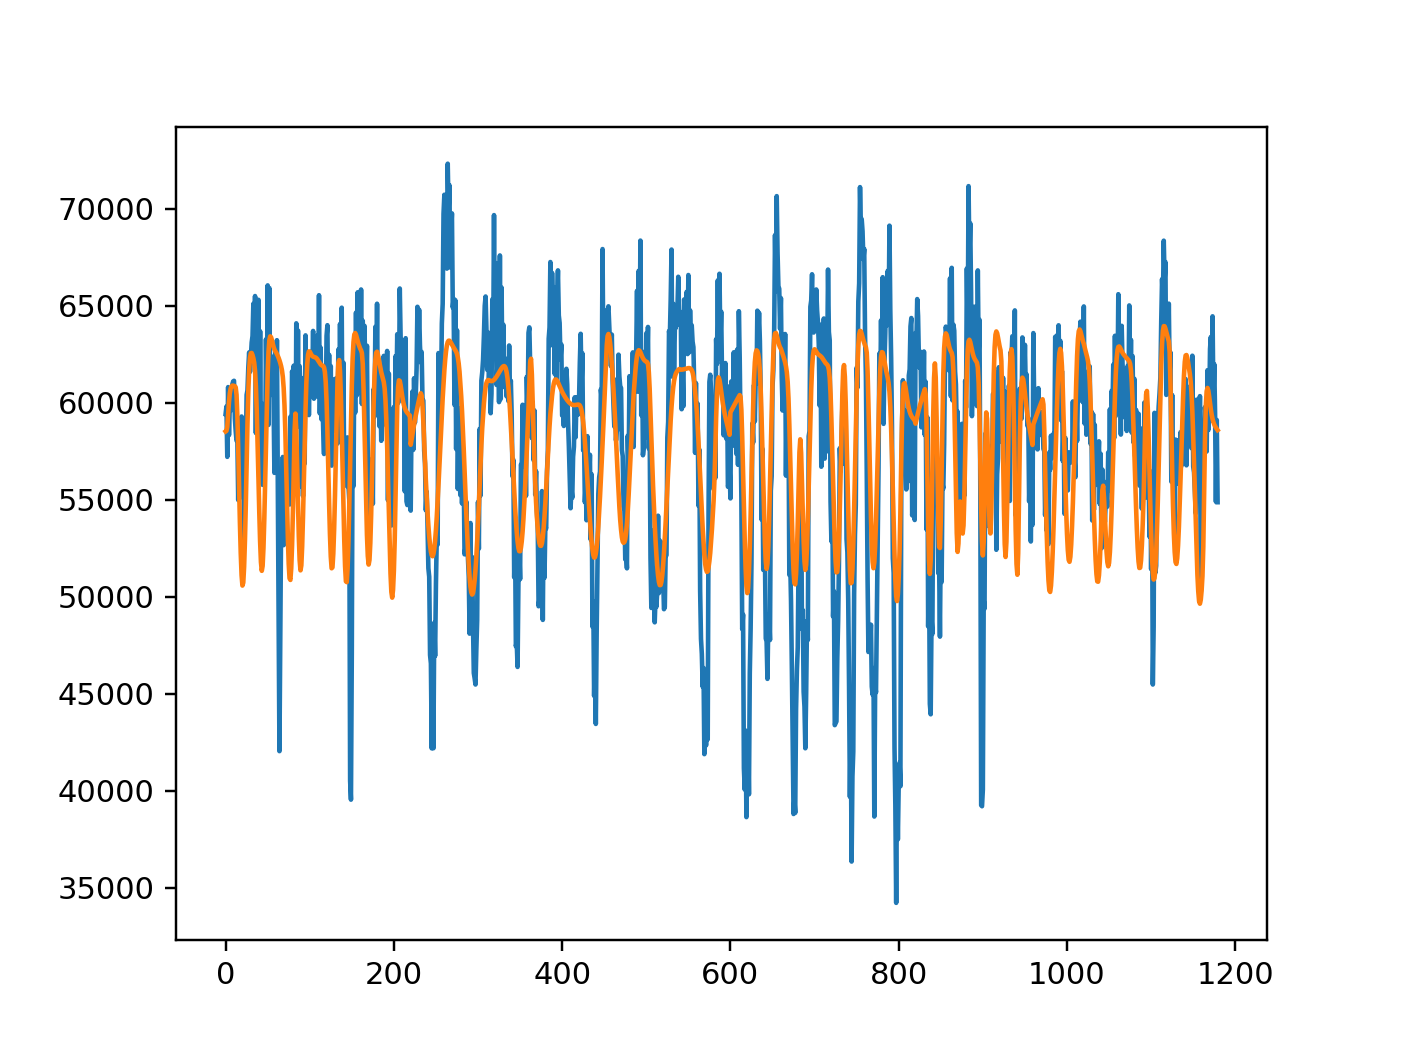

In [26]:
%matplotlib notebook
fig=pl.figure()
pl.plot(tc_full_iso_nonzerovar_dict['tc'][gf.rsq_mask,:][vox])
#pl.plot(gg_norm.return_single_prediction(*list(current_result[np.where(gridsearch_params[:,-1]>0.66),:][0,vox,:-1])))
pl.plot(gg_norm.return_single_prediction(*list(gf_norm.iterative_search_params[gf.rsq_mask,:][vox,:-1])))
